# Kaggle Competitions: How and where to begin?

## Cross Industry Standard Process for Data Mining (CRISP-DM)
<img src="CRISP-DM_Process_Diagram.png" width="50%">

[Link](https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining)

- **Business Understanding** 

   Understand the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary plan designed to achieve the objectives.
   

- **Data Understanding** 

    To get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.
    

- **Data Preparation**

    The data preparation phase covers all activities to construct the final dataset from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order.
    

- **Modeling**

    In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often needed.
    

- **Evaluation**

    It is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

## Sberbank Russian Housing Market

- **Description** ([link](https://www.kaggle.com/c/sberbank-russian-housing-market#description))

    In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.
    
    
- **Evaluation** ([link](https://www.kaggle.com/c/sberbank-russian-housing-market#evaluation))
    
    Submissiona are evaluated on the **Root Mean Squared Logarithmic Error** ([RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)) between their predicted prices and the actual data.
    
    
- **Data** ([link](https://www.kaggle.com/c/sberbank-russian-housing-market/data))

    Most of the Kaggle competitions come with a **training dataset**, a **test dataset** and a **data discription**. You will need to train your model based on the training set and make prediction on the test set. 
    
    Your scores on the Leaderboard are evaluated based on part of the test set. The final results will be based on the other part, so the final standings may be different.
    
    In this competition, the training data is from August 2011 to June 2015, and the test set is from July 2015 to May 2016. The dataset also includes information about overall conditions in Russia's economy and finance sector, so you can focus on generating accurate price forecasts for individual properties, without needing to second-guess what the business cycle will do.
    

- **Kaggle Kernels** ([link](https://www.kaggle.com/c/sberbank-russian-housing-market/kernels))
    
    The best place to learn from other Kagglers. 
    
    Some useful kernels:
    
    - A Very Extensive Sberbank Exploratory Analysis ([link](https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis))
    - Map visualizations with external shapefile ([link](https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile))
    - Naive XGB [LB ~0.317] ([link](https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317))

    - [R] XGB Starter + Basic Features [~0.33 LB]
([link](https://www.kaggle.com/kevinbonnes/r-xgb-starter-basic-features-0-33-lb/code))

In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
from pandas.plotting import scatter_matrix
%matplotlib inline

DIR_PATH = './'

/home/mes/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [59]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')

### Data Understanding & Data Preparation

In [3]:
## data schema
train_schema = pd.DataFrame(build_table_schema(train_raw)['fields'])
macro_schema = pd.DataFrame(build_table_schema(macro)['fields'])

In [4]:
## start from property features first
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                     'max_floor', 'material', 'build_year', 'num_room',
                     'kitch_sq', 'state', 'product_type', 'sub_area', 
                     'price_doc']

train = train_raw[property_features]
test = test_raw[property_features[:-1]]

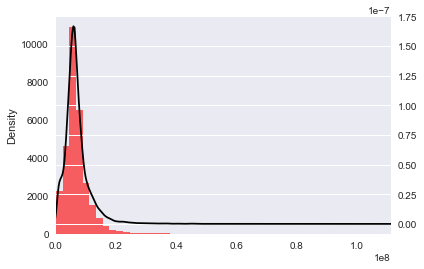

In [5]:
## distribution of price_doc
vis.hist_density_plot(train, x='price_doc')

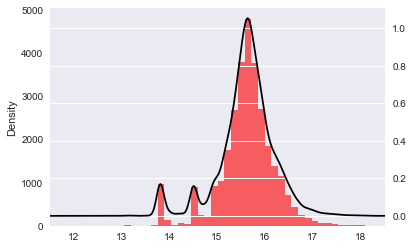

In [6]:
## distribution of log(price_doc+1)
vis.hist_density_plot(train, x='price_doc', logx=True)

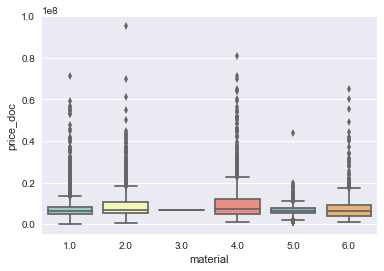

In [7]:
## material
col = 'material'
sns.boxplot(x=col, 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [8]:
print(train[col].value_counts(dropna=False))
print(test[col].value_counts(dropna=False))

 1.0    14197
NaN      9572
 2.0     2993
 5.0     1561
 4.0     1344
 6.0      803
 3.0        1
Name: material, dtype: int64
1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64


In [9]:
train.loc[train[col] == 3, col] = np.nan
test.loc[test[col] == 3, col] = np.nan

/home/mes/venv/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


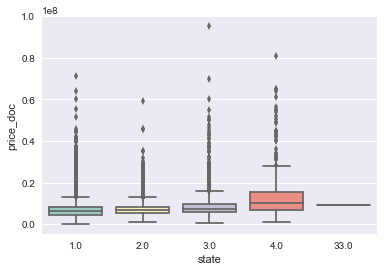

In [10]:
## state
sns.boxplot(x='state', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [11]:
print(train['state'].value_counts(dropna=False))
print(test['state'].value_counts(dropna=False))

NaN      13559
 2.0      5844
 3.0      5790
 1.0      4855
 4.0       422
 33.0        1
Name: state, dtype: int64
 2.0    2662
 1.0    2266
 3.0    1913
NaN      694
 4.0     127
Name: state, dtype: int64


In [12]:
train.loc[train['state'] == 33,:]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
10092,2013-08-27,37,16.0,8.0,12.0,1.0,20052009.0,1.0,9.0,33.0,Investment,Cheremushki,9000000


In [13]:
## change 33 to 3
train.loc[train['state'] == 33, col] = 3

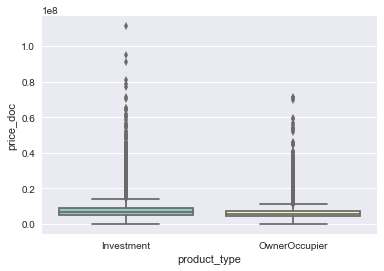

In [14]:
## product_type
sns.boxplot(x='product_type', 
            y='price_doc', 
            data=train, 
            palette='Set3')

In [15]:
print(train['product_type'].value_counts(dropna=False))
print(test['product_type'].value_counts(dropna=False))

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64
Investment       4998
OwnerOccupier    2631
NaN                33
Name: product_type, dtype: int64


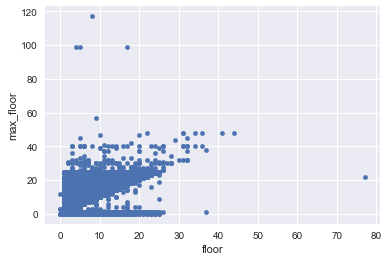

In [16]:
## floor / max_floor
train.plot.scatter(x='floor', y='max_floor')

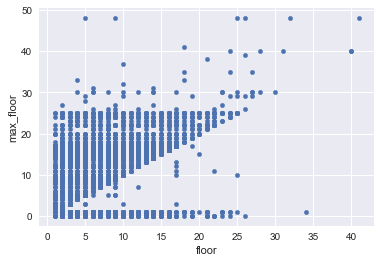

In [17]:
test.plot.scatter(x='floor', y='max_floor')

In [18]:
## max_floor
train.loc[train['max_floor'] > 60]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
20725,2014-07-10,47,47.0,4.0,99.0,2.0,NaN,1.0,1.0,NaN,OwnerOccupier,Pokrovskoe Streshnevo,10238400
21737,2014-08-21,71,71.0,5.0,99.0,6.0,NaN,2.0,9.0,NaN,OwnerOccupier,Poselenie Moskovskij,8484365
21855,2014-08-25,46,46.0,17.0,99.0,6.0,NaN,3.0,9.0,NaN,OwnerOccupier,Poselenie Sosenskoe,6670000
25943,2014-12-06,63,63.0,8.0,117.0,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,Tverskoe,7239838


In [19]:
train.loc[train['max_floor'] == 117, col] = 17
train.loc[train['max_floor'] > 60, col] = np.nan

In [20]:
## floor
train.loc[train['floor'] > 60]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
23587,2014-10-15,57,33.0,77.0,22.0,1.0,1986.0,2.0,10.0,3.0,Investment,Lomonosovskoe,13700000


In [21]:
train.loc[train['floor'] == 77, col] = 7

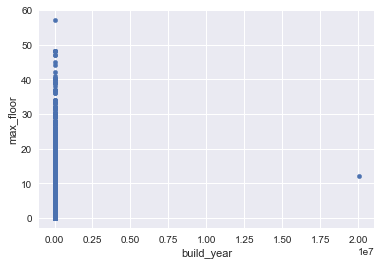

In [22]:
## build_year (training set)
train.plot.scatter(x='build_year', y='max_floor')

In [23]:
train['build_year'].value_counts(dropna=False).sort_index()

 0.0             530
 1.0             368
 3.0               2
 20.0              1
 71.0              1
 215.0             1
 1691.0            1
 1860.0            2
 1876.0            1
 1886.0            1
 1890.0            5
 1895.0            1
 1896.0            2
 1900.0            2
 1904.0            1
 1905.0            1
 1906.0            1
 1907.0            2
 1910.0            5
 1911.0            1
 1912.0            5
 1914.0            3
 1915.0            5
 1917.0           16
 1920.0            1
 1924.0            3
 1925.0            1
 1926.0            8
 1927.0           10
 1928.0           12
               ...  
 1992.0          139
 1993.0          115
 1994.0          160
 1995.0          149
 1996.0          162
 1997.0          139
 1998.0          141
 1999.0          125
 2000.0          130
 2001.0          177
 2002.0          214
 2003.0          193
 2004.0          220
 2005.0          176
 2006.0          242
 2007.0          219
 2008.0      

In [24]:
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
train.loc[train['build_year'] == 71, 'build_year'] = 1971
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan

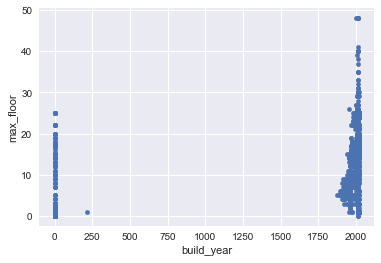

In [25]:
## build_year (test set)
test.plot.scatter(x='build_year', y='max_floor')

In [26]:
test['build_year'].value_counts(dropna=False).sort_index()

 0.0        369
 1.0        187
 2.0          1
 215.0        1
 1875.0       1
 1890.0       2
 1895.0       1
 1898.0       1
 1902.0       1
 1905.0       1
 1906.0       1
 1908.0       1
 1910.0       1
 1911.0       3
 1912.0       1
 1914.0       2
 1917.0       3
 1924.0       1
 1926.0       8
 1927.0       3
 1928.0       6
 1929.0       4
 1930.0       3
 1931.0       3
 1932.0       3
 1933.0       1
 1935.0       1
 1937.0       5
 1938.0       3
 1939.0       3
           ... 
 1991.0      28
 1992.0      56
 1993.0      39
 1994.0      49
 1995.0      40
 1996.0      44
 1997.0      58
 1998.0      46
 1999.0      53
 2000.0      56
 2001.0      63
 2002.0      65
 2003.0      61
 2004.0      66
 2005.0      65
 2006.0      92
 2007.0      46
 2008.0      74
 2009.0      58
 2010.0      47
 2011.0      61
 2012.0      74
 2013.0     260
 2014.0     199
 2015.0     259
 2016.0     400
 2017.0     413
 2018.0      30
 2019.0       5
NaN        1049
Name: build_year, Length

In [27]:
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5282504cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5281fa5e10>]], dtype=object)

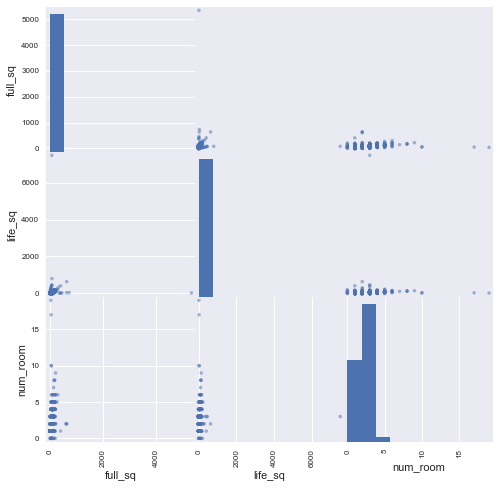

In [28]:
## num_room / full_sq / life_sq (training set)
scatter_matrix(train.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(8, 8), 
               diagonal='hist')

In [29]:
## num_room
train.loc[train['num_room'] > 9]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
11624,2013-10-28,40,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,3.0,Investment,Poselenie Vnukovskoe,2630000
17767,2014-04-23,58,34.0,1.0,2.0,1.0,1992.0,10.0,10.0,2.0,Investment,Krjukovo,6000000
26716,2014-12-18,51,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,3.0,Investment,Obruchevskoe,13150000
29175,2015-04-16,59,33.0,20.0,22.0,1.0,2000.0,10.0,10.0,3.0,Investment,Mar'ino,11000000


In [30]:
train.loc[train['num_room'] > 9, 'num_room'] = np.nan

In [31]:
## full_sq 
train.loc[train['full_sq'] > 300]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
129,2011-10-15,325,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ivanovskoe,5000000
1481,2012-03-11,353,20.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Solncevo,4750000
1613,2012-03-21,394,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ljublino,1050000
2428,2012-06-07,412,17.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Filevskij Park,6117000
2783,2012-07-06,729,44.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Troparevo-Nikulino,13250000
3530,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Birjulevo Vostochnoe,6868818
3599,2012-09-12,388,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Nekrasovka,3899400
5947,2013-02-07,634,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Lianozovo,10200000
7210,2013-04-10,461,27.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Vyhino-Zhulebino,5750000


In [32]:
train.loc[train['full_sq'] > 1000, 'full_sq'] = train.loc[train['full_sq'] > 1000, 'full_sq']/100
train.loc[train['full_sq'] > 310, 'full_sq'] = train.loc[train['full_sq'] > 310, 'full_sq']/10

In [33]:
train.loc[(train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
129,2011-10-15,32.5,325.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ivanovskoe,5000000
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6200000
1866,2012-04-11,30.0,178.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Presnenskoe,5900000
4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Vojkovskoe,11918400
6339,2013-03-06,37.0,191.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Kosino-Uhtomskoe,5400000
7211,2013-04-10,31.0,195.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Cheremushki,6400000
9240,2013-07-16,47.0,301.0,4.0,12.0,1.0,1973.0,2.0,6.0,2.0,Investment,Birjulevo Zapadnoe,5600000
9259,2013-07-17,77.0,458.0,12.0,16.0,1.0,1996.0,3.0,10.0,3.0,Investment,Jasenevo,13750000
9649,2013-08-06,82.0,802.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Chertanovo Juzhnoe,12031350


In [34]:
## life_sq
train.loc[13549, 'life_sq'] = train.loc[13549, 'life_sq'] / 100

In [35]:
rows = (train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)
train.loc[rows, 'life_sq'] = train.loc[rows, 'life_sq'] / 10

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5282345a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f52819411d0>]], dtype=object)

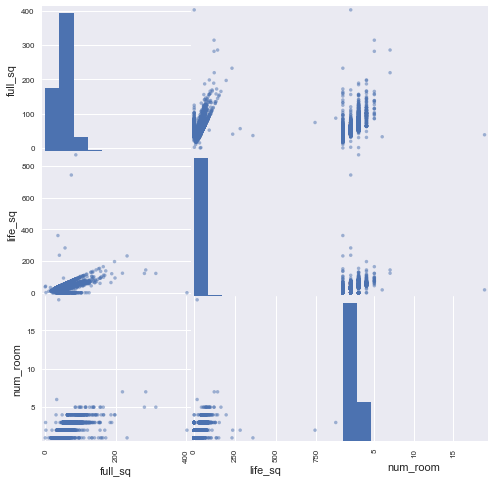

In [36]:
## num_room / full_sq / life_sq (test set)
scatter_matrix(test.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(8, 8), 
               diagonal='hist')

In [37]:
## num_room
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

In [38]:
## full_sq 
test.loc[test['full_sq'] > 400, 'full_sq'] = test.loc[test['full_sq'] > 400, 'full_sq'] / 10

In [39]:
## life_sq
rows = (test['full_sq'] < test['life_sq']) & (test['life_sq'] > 110)
test.loc[rows]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area
id,,,,,,,,,,,,
31075,2015-08-17,74.2,742.0,2,17,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,Poselenie Sosenskoe
32370,2015-10-23,36.1,361.0,14,14,4.0,NaN,1.0,0.0,1.0,OwnerOccupier,Poselenie Sosenskoe
32505,2015-10-30,40.2,237.0,11,11,1.0,2016.0,2.0,67.0,1.0,OwnerOccupier,Horoshevo-Mnevniki
33265,2015-12-01,86.9,869.0,3,20,4.0,NaN,3.0,0.0,1.0,OwnerOccupier,Chertanovo Juzhnoe
35661,2016-02-15,56.3,283.0,7,17,1.0,2014.0,2.0,8.3,2.0,Investment,Sokolinaja Gora


In [40]:
test.loc[rows, 'life_sq'] = test.loc[rows, 'life_sq'] / 10

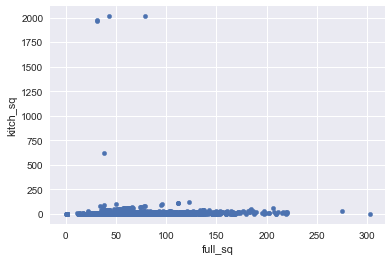

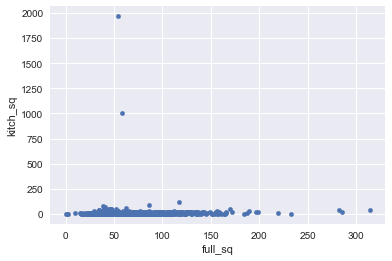

In [41]:
## kitch_sq
train.plot.scatter(x='full_sq', y='kitch_sq')
test.plot.scatter(x='full_sq', y='kitch_sq')

In [42]:
rows = (train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100)
train.loc[rows]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,price_doc
id,,,,,,,,,,,,,
10371,2013-09-10,79.0,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,7281225
11523,2013-10-24,38.0,23.0,11.0,14.0,5.0,1971.0,2.0,620.0,2.0,Investment,Novogireevo,6300000
13120,2013-12-14,31.0,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,3.0,Investment,Izmajlovo,3650000
21418,2014-08-11,43.0,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,1.0,OwnerOccupier,Poselenie Sosenskoe,3801200
28737,2015-03-31,31.0,16.0,2.0,12.0,5.0,1972.0,1.0,1974.0,3.0,Investment,Matushkino,1000000


In [43]:
train.loc[13120, 'build_year'] = 1970
train.loc[11523, 'kitch_sq'] = train.loc[11523, 'kitch_sq'] / 100
rows = (train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100)
train.loc[rows, 'kitch_sq'] = np.nan

In [44]:
rows = (test['kitch_sq'] > test['full_sq']) & (test['kitch_sq'] > 100)
test.loc[rows]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area
id,,,,,,,,,,,,
31381,2015-09-01,53.9,32.1,3,9,1.0,1968.0,2.0,1968.0,2.0,Investment,Severnoe Medvedkovo
36811,2016-03-19,58.5,58.5,15,17,1.0,2017.0,2.0,1000.0,NaN,OwnerOccupier,Poselenie Desjonovskoe


In [45]:
test.loc[rows, 'kitch_sq'] = np.nan

/home/mes/venv/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


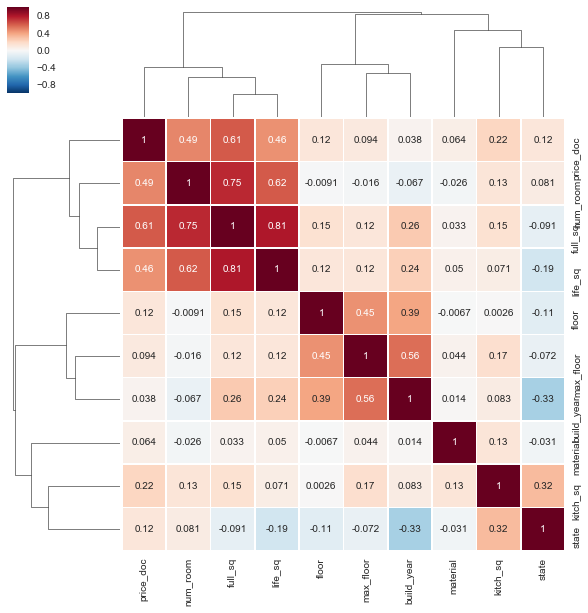

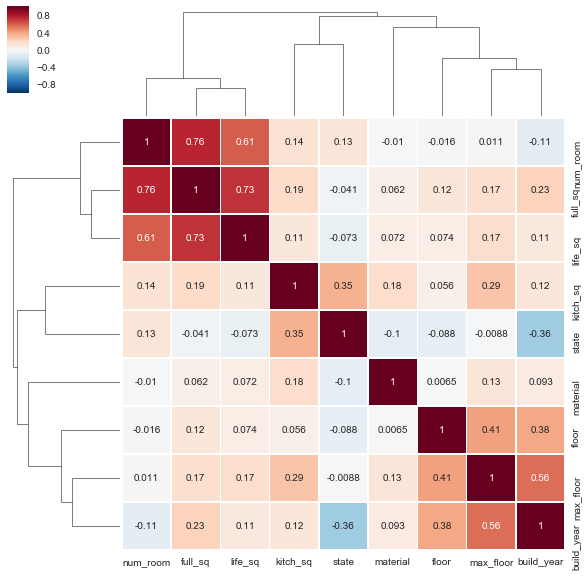

In [46]:
## correlation
vis.corr_plot(train)
vis.corr_plot(test)

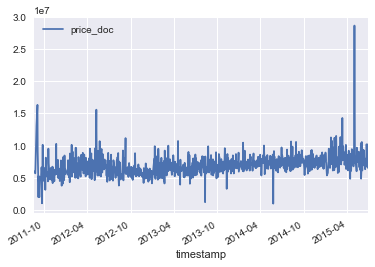

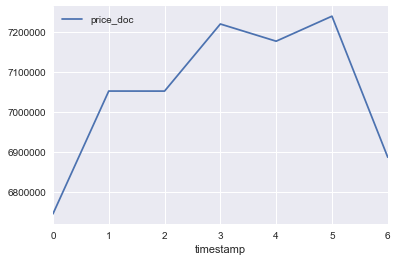

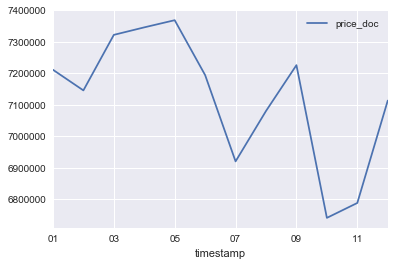

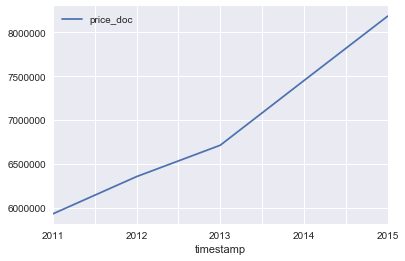

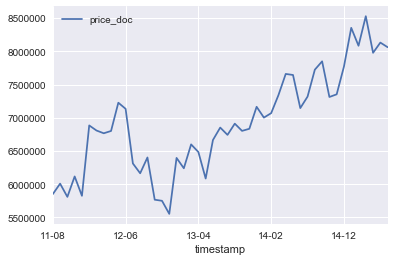

In [47]:
## time series analysis - price_doc

vis.timeseries_plot(train, val='price_doc', by='day')    
vis.timeseries_plot(train, val='price_doc', by='weekday')    
vis.timeseries_plot(train, val='price_doc', by='month')    
vis.timeseries_plot(train, val='price_doc', by='year')
vis.timeseries_plot(train, val='price_doc', by='%Y-%m')

/home/mes/venv/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


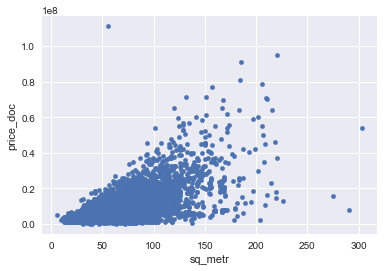

In [48]:
## time series analysis - unit_price

## property square meters
train.loc[:, 'sq_metr'] = train.loc[:, ['full_sq','life_sq']].max(axis=1)
train.loc[train['sq_metr'] < 6, 'sq_metr'] = np.nan
train.plot.scatter(x='sq_metr', y='price_doc')

In [49]:
## remove outlier (price_doc)
train = train.drop(train[train['price_doc'] > 1e8].index)

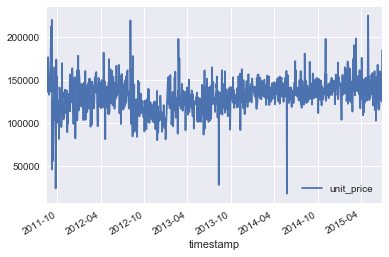

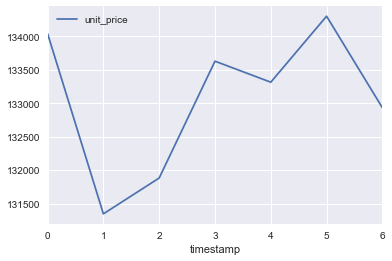

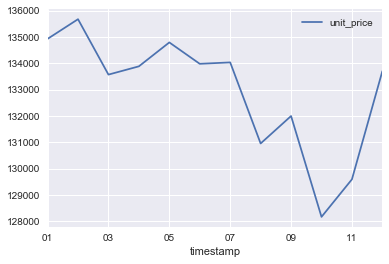

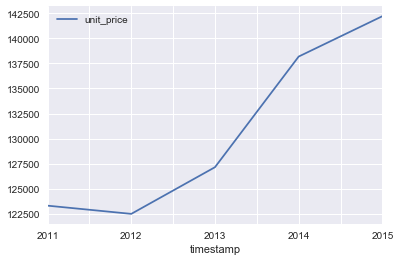

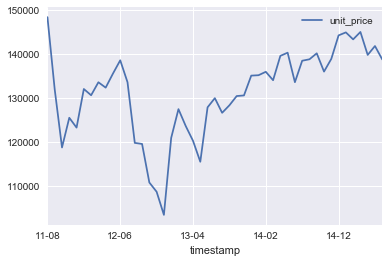

In [50]:
test.loc[:, 'sq_metr'] = test.loc[:, ['full_sq','life_sq']].max(axis=1)

## property unit_price
train.loc[:, 'unit_price'] = train.loc[:, 'price_doc'] / train.loc[:, 'sq_metr']

## time series
## unit_price
vis.timeseries_plot(train, val='unit_price', by='day')
vis.timeseries_plot(train, val='unit_price', by='weekday')    
vis.timeseries_plot(train, val='unit_price', by='month')    
vis.timeseries_plot(train, val='unit_price', by='year') 
vis.timeseries_plot(train, val='unit_price', by='%Y-%m') 

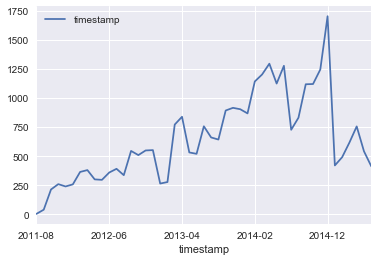

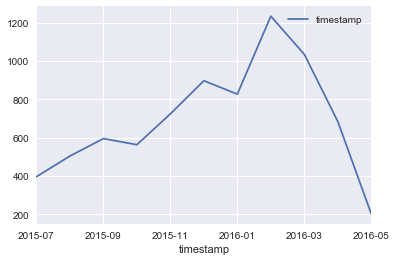

In [51]:
## time series analysis - transaction volumns
by_what = train['timestamp'].apply(lambda x: x.strftime('%Y-%m'))
train.loc[:, ['timestamp']].groupby(by_what).count().plot()

by_what = test['timestamp'].apply(lambda x: x.strftime('%Y-%m'))
test.loc[:, ['timestamp']].groupby(by_what).count().plot()

### Modeling

In [52]:
## log transformation
train.loc[:, 'log_price_doc'] = np.log(train['price_doc'] + 1)

In [53]:
## time features
train.loc[:, 'year'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
train.loc[:, 'month'] = train.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

test.loc[:, 'year'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
test.loc[:, 'month'] = test.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

In [54]:
## sub_area
freq_area = np.array(train.loc[:, 'sub_area'].value_counts()[:30].index)

train.loc[~train['sub_area'].isin(freq_area), 'sub_area'] = 'other'
test.loc[~test['sub_area'].isin(freq_area), 'sub_area'] = 'other'

In [58]:
## label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = dict()

for feature in ['product_type', 'sub_area']:
    print('encoding feature: {}'.format(feature))
    label_encoder[feature] = LabelEncoder()
    label_encoder[feature].fit(train[feature])
    train.loc[:, feature + '_le'] = label_encoder[feature].transform(train[feature])
    test.loc[:, feature + '_le'] = label_encoder[feature].transform(test[feature])

encoding feature: product_type


ValueError: y contains new labels: [nan]

In [ ]:
# Convert to numpy values
property_features = ['year', 'month', 'full_sq', 'life_sq', 'floor', 
                    'max_floor', 'material', 'build_year', 'num_room',
                    'kitch_sq', 'state']

X_train = train[property_features].values
Y_train = train['log_price_doc'].values
X_test = test[property_features].values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

In [ ]:
size_ = 7000
X_train_sub, Y_train_sub = X_train[:-size_],  Y_train[:-size_]
X_val, Y_val = X_train[-size_:],  Y_train[-size_:]

In [ ]:
# Create a validation set, with last 20% of data
dtrain = xgb.DMatrix(X_train, 
                    Y_train, 
                    feature_names=property_features)
dtrain_sub = xgb.DMatrix(X_train_sub, 
                        Y_train_sub, 
                        feature_names=property_features)
d_val = xgb.DMatrix(X_val, 
                    Y_val, 
                    feature_names=property_features)
dtest = xgb.DMatrix(X_test, 
                    feature_names=property_features)

In [ ]:
# hyperparameters
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
sub_model = xgb.train(xgb_params, 
                      dtrain_sub, 
                      num_boost_round=2000,
                      evals=[(d_val, 'val')],
                      early_stopping_rounds=20, 
                      verbose_eval=20)

In [ ]:
xgb.plot_importance(sub_model)

In [ ]:
full_model = xgb.train(xgb_params,
                       dtrain, 
                       num_boost_round=sub_model.best_iteration,
                       verbose_eval=20)

In [ ]:
log_y_pred = full_model.predict(dtest)
y_pred = np.exp(log_y_pred) - 1

In [ ]:
submit = pd.DataFrame({'id': np.array(test.index), 'price_doc': y_pred})
submit.to_csv('submission.csv', index=False)

### What's next?

<img src="TechnicalDebt.png">

[source](https://papers.nips.cc/paper/5656-hidden-technical-debt-in-machine-learning-systems.pdf)

- Understand the remaining features
- Understand the macro data
- Feature extraction/engineering
- Missing data imputation
- Time series analysis
- Try More machine learning models with Cross Validation
- Ensemble/Stacking models

## Save changes back to a csv